# **Coco Dataset Notebook and Inference Notebook**

https://www.kaggle.com/vexxingbanana/sartorius-coco-dataset-notebook

https://www.kaggle.com/vexxingbanana/mmdetection-neuron-inference

# **References**

https://www.kaggle.com/dschettler8845/sartorius-segmentation-eda-and-baseline

https://www.kaggle.com/ihelon/cell-segmentation-run-length-decoding

https://www.kaggle.com/stainsby/fast-tested-rle

https://www.kaggle.com/paulorzp/run-length-encode-and-decode

https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer

https://www.kaggle.com/awsaf49/sartorius-mmdetection-train

https://www.kaggle.com/evancofsky/sartorius-torch-lightning-mask-r-cnn/notebook

# Notes

* Trying out more epochs, added more augmentations, increased batch size to 2, and using validation dataset.
* Added mixed precision, reduced epochs back to 12, removed CLAHE augmentation.
* Increased confidence on inference of bboxes to 0.5, removed validation.
* Trying out more epochs, added back 5% validation, changed normalization to the dataset, changed to 3 classes.

Please consider upvoting if you find this helpful. :)

# **Install MMDetection and MMDetection-Compatible Torch**

In [1]:
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torch-1.7.0+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchvision-0.8.1+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchaudio-0.7.0-cp37-cp37m-linux_x86_64.whl' --no-deps

Processing /kaggle/input/pytorch-170-cuda-toolkit-110221/torch-1.7.0+cu110-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
Processing /kaggle/input/pytorch-170-cuda-toolkit-110221/torchvision-0.8.1+cu110-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
Processing /kaggle/input/pytorch-170-cuda-toolkit-110221/torchaudio-0.7.0-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1


In [2]:
!pip install '/kaggle/input/mmdetectionv2140/addict-2.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/yapf-0.31.0-py2.py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminal-0.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminaltables-3.1.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmcv_full-1_3_8-cu110-torch1_7_0/mmcv_full-1.3.8-cp37-cp37m-manylinux1_x86_64.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmpycocotools-12.0.3/mmpycocotools-12.0.3' --no-deps

!rm -rf mmdetection

!cp -r /kaggle/input/mmdetectionv2140/mmdetection-2.14.0 /kaggle/working/
!mv /kaggle/working/mmdetection-2.14.0 /kaggle/working/mmdetection
%cd /kaggle/working/mmdetection
!pip install -e .

Processing /kaggle/input/mmdetectionv2140/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetectionv2140/yapf-0.31.0-py2.py3-none-any.whl
Processing /kaggle/input/mmdetectionv2140/terminal-0.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetectionv2140/terminaltables-3.1.0-py3-none-any.whl
Processing /kaggle/input/mmdetectionv2140/mmcv_full-1_3_8-cu110-torch1_7_0/mmcv_full-1.3.8-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272237 s

# **Import Libraries** 

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import sklearn
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
import json
from PIL import Image, ImageEnhance
import albumentations as A
import mmdet
import mmcv
from albumentations.pytorch import ToTensorV2
import seaborn as sns
import glob
from pathlib import Path
import pycocotools
from pycocotools import mask
import numpy.random
import random
import cv2
import re
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot, set_random_seed

In [4]:
%cd ..

/kaggle/working


In [6]:
IMG_WIDTH = 704
IMG_HEIGHT = 520

# **Helper Functions**

In [7]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]


def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

In [8]:
def get_img_and_mask(img_path, annotation, width, height):
    """ Capture the relevant image array as well as the image mask """
    img_mask = np.zeros((height, width), dtype=np.uint8)
    for i, annot in enumerate(annotation): 
        img_mask = np.where(rle_decode(annot, (height, width))!=0, i, img_mask)
    img = cv2.imread(img_path)[..., ::-1]
    return img[..., 0], img_mask

def plot_img_and_mask(img, mask, invert_img=True, boost_contrast=True):
    """ Function to take an image and the corresponding mask and plot
    
    Args:
        img (np.arr): 1 channel np arr representing the image of cellular structures
        mask (np.arr): 1 channel np arr representing the instance masks (incrementing by one)
        invert_img (bool, optional): Whether or not to invert the base image
        boost_contrast (bool, optional): Whether or not to boost contrast of the base image
        
    Returns:
        None; Plots the two arrays and overlays them to create a merged image
    """
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    _img = np.tile(np.expand_dims(img, axis=-1), 3)
    
    # Flip black-->white ... white-->black
    if invert_img:
        _img = _img.max()-_img
        
    if boost_contrast:
        _img = np.asarray(ImageEnhance.Contrast(Image.fromarray(_img)).enhance(16))
        
    plt.imshow(_img)
    plt.axis(False)
    plt.title("Cell Image", fontweight="bold")
    
    plt.subplot(1,3,2)
    _mask = np.zeros_like(_img)
    _mask[..., 0] = mask
    plt.imshow(mask, cmap='rainbow')
    plt.axis(False)
    plt.title("Instance Segmentation Mask", fontweight="bold")
    
    merged = cv2.addWeighted(_img, 0.75, np.clip(_mask, 0, 1)*255, 0.25, 0.0,)
    plt.subplot(1,3,3)
    plt.imshow(merged)
    plt.axis(False)
    plt.title("Cell Image w/ Instance Segmentation Mask Overlay", fontweight="bold")
    
    plt.tight_layout()
    plt.show()

In [9]:
def polygonFromMask(maskedArr, idx):
    
    # adapted from https://github.com/hazirbas/coco-json-converter/blob/master/generate_coco_json.py
    contours, _ = cv2.findContours(maskedArr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    valid_poly = 0
    for contour in contours:
        
    # Valid polygons have >= 6 coordinates (3 points)
        if contour.size >= 6:
            segmentation.append(contour.astype(float).flatten().tolist())
            valid_poly += 1
    if valid_poly == 0:
        raise ValueError(idx)
    
    return [segmentation]

# **Data Visualizations**

In [10]:
train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

In [11]:
train_df.head(2)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [12]:
lines = []
for f in train_df.itertuples():
    lines.append('../input/sartorius-cell-instance-segmentation/train/' + f[1] + '.png')

In [13]:
lins = pd.Series(lines, name='img_path')

In [14]:
train_df = pd.concat([train_df, lins], axis=1)

In [15]:
tmp_df = train_df.drop_duplicates(subset=["id", "img_path"]).reset_index(drop=True)
tmp_df["annotation"] = train_df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
train_df = tmp_df.copy()

In [16]:
train_df.head(2)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,img_path
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,../input/sartorius-cell-instance-segmentation/...
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,../input/sartorius-cell-instance-segmentation/...


In [17]:
def plot_mask(idx):
    im, mk = get_img_and_mask(**train_df[["img_path", "annotation", "width", "height"]].iloc[idx].to_dict())
    plot_img_and_mask(im, mk)

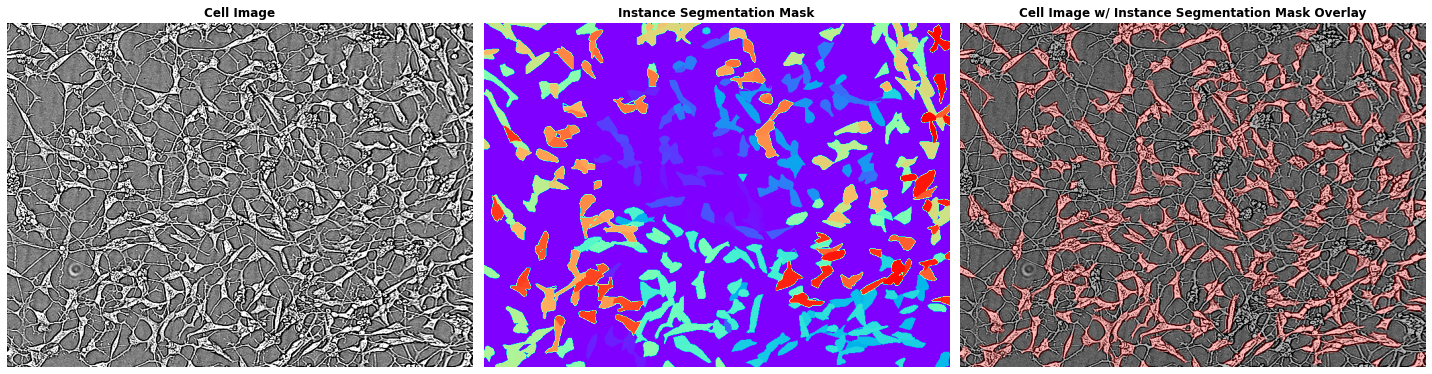

In [18]:
plot_mask(0)

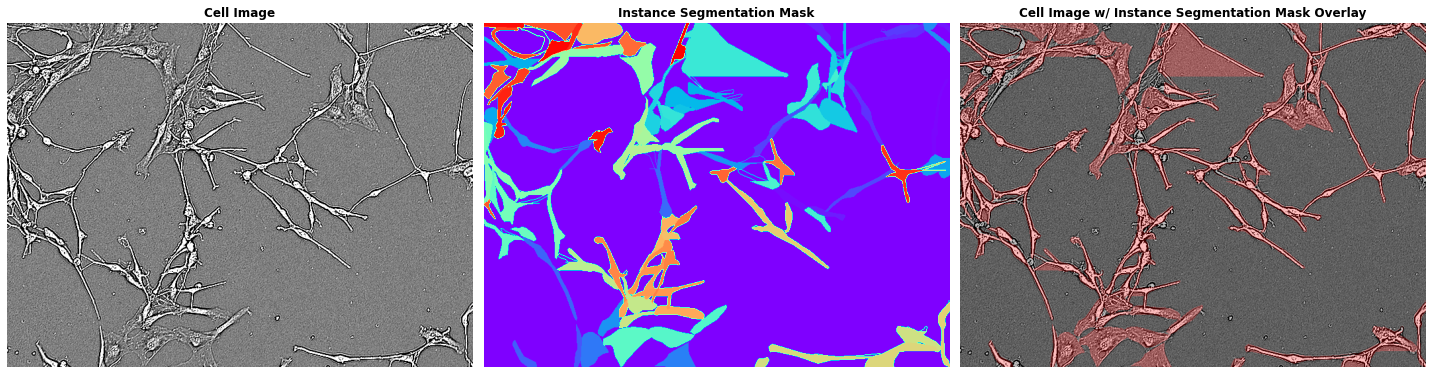

In [19]:
plot_mask(1)

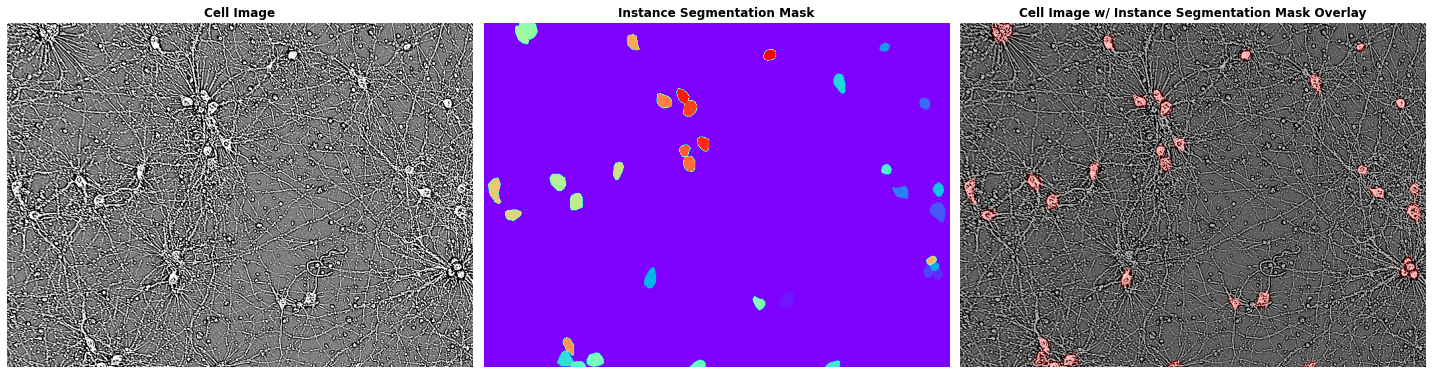

In [20]:
plot_mask(2)

In [21]:
train_df, val_df = train_test_split(train_df, train_size=0.95, random_state=0)

In [22]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [23]:
%%writefile labels.txt
shsy5y
cort
astro

Writing labels.txt


# **Model Config**

In [24]:
from mmcv import Config
# cfg = Config.fromfile('/kaggle/working/mmdetection/configs/htc/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco.py')
cfg = Config.fromfile('/kaggle/working/mmdetection/configs/ms_rcnn/ms_rcnn_x101_64x4d_fpn_1x_coco.py')
# cfg = Config.fromfile('/kaggle/working/mmdetection/configs/cascade_rcnn/cascade_mask_rcnn_r50_fpn_20e_coco.py')

In [25]:
print(cfg.pretty_text)

model = dict(
    type='MaskScoringRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'),
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
 

In [ ]:
model = dict(
    type='MaskScoringRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'), # mod
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='MaskScoringRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=80,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0.0, 0.0, 0.0, 0.0],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=80,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0)),
        mask_iou_head=dict(
            type='MaskIoUHead',
            num_convs=4,
            num_fcs=2,
            roi_feat_size=14,
            in_channels=256,
            conv_out_channels=256,
            fc_out_channels=1024,
            num_classes=80)),
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            mask_size=28,
            pos_weight=-1,
            debug=False,
            mask_thr_binary=0.5)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.5),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100,
            mask_thr_binary=0.5)))
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='CocoDataset',
        ann_file='data/coco/annotations/instances_train2017.json',
        img_prefix='data/coco/train2017/',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
            dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(
                type='Collect',
                keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
        ]),
    val=dict(
        type='CocoDataset',
        ann_file='data/coco/annotations/instances_val2017.json',
        img_prefix='data/coco/val2017/',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CocoDataset',
        ann_file='data/coco/annotations/instances_val2017.json',
        img_prefix='data/coco/val2017/',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))
evaluation = dict(metric=['bbox', 'segm'])
# optimizer = dict(type='SGD', lr=0.02, momentum=0.9, weight_decay=0.0001)
optimizer = dict(type='Adam', lr=0.02, momentum=0.9, weight_decay=0.0001) #mod
optimizer_config = dict(grad_clip=None)
# lr_config = dict(
#     policy='step',
#     warmup='linear',
#     warmup_iters=500,
#     warmup_ratio=0.001,
#     step=[8, 11])
lr_config = dict(
    policy='CosineAnnealing',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    min_lr_ratio=1e-5,
    step=[8, 11])
runner = dict(type='EpochBasedRunner', max_epochs=25) 3mod
checkpoint_config = dict(interval=1)
log_config = dict(interval=5, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]

In [ ]:
!mkdir /kaggle/working/mmdetection/configs/sartorius/

In [ ]:
!wget https://download.openmmlab.com/mmdetection/v2.0/ms_rcnn/ms_rcnn_x101_64x4d_fpn_1x_coco/ms_rcnn_x101_64x4d_fpn_1x_coco_20200206-86ba88d2.pth -P /kaggle/working/mmdetection/configs/sartorius/

In [ ]:
cfg.dataset_type = 'CocoDataset'
cfg.classes = '/kaggle/working/labels.txt'
cfg.data_root = '/kaggle/working'

# for head in cfg.model.roi_head.bbox_head:
#     head.num_classes = 3
cfg.model.roi_head.bbox_head.num_classes=3
# for head in cfg.model.roi_head.mask_head:
#     head.num_classes = 3
    
# cfg.model.roi_head.mask_head.semantic_head.num_classes=3
cfg.model.roi_head.mask_head.num_classes=3

cfg.model.roi_head.mask_iou_head.num_classes=3


cfg.data.test.type = 'CocoDataset'
cfg.data.test.classes = 'labels.txt'
cfg.data.test.data_root = '/kaggle/working'
cfg.data.test.ann_file = '../input/k/vexxingbanana/sartorius-coco-dataset-notebook/val_dataset.json'
cfg.data.test.img_prefix = ''

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = '/kaggle/working'
cfg.data.train.ann_file = '../input/k/vexxingbanana/sartorius-coco-dataset-notebook/train_dataset.json'
cfg.data.train.img_prefix = ''
cfg.data.train.classes = 'labels.txt'

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = '/kaggle/working'
cfg.data.val.ann_file = '../input/k/vexxingbanana/sartorius-coco-dataset-notebook/val_dataset.json'
cfg.data.val.img_prefix = ''
cfg.data.val.classes = 'labels.txt'

albu_train_transforms = [
    dict(type='ShiftScaleRotate', shift_limit=0.0625,
         scale_limit=0.15, rotate_limit=15, p=0.4),
    dict(type='RandomBrightnessContrast', brightness_limit=0.2,
         contrast_limit=0.2, p=0.5),
#     dict(type='IAAAffine', shear=(-10.0, 10.0), p=0.4),
#     dict(type='CLAHE', p=0.5),
    dict(
        type="OneOf",
        transforms=[
            dict(type="GaussianBlur", p=1.0, blur_limit=7),
            dict(type="MedianBlur", p=1.0, blur_limit=7),
        ],
        p=0.4,
    ),
]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
#     dict(type='Resize', img_scale=[(440, 596), (480, 650), (520, 704), (580, 785), (620, 839)], multiscale_mode='value', keep_ratio=True),
#     dict(type='Resize', img_scale=[(880, 1192), (960, 130), (1040, 1408), (1160, 1570), (1240, 1678)], multiscale_mode='value', keep_ratio=True),
    dict(type='Resize', img_scale=[(1333, 800), (1690, 960)]),
#     dict(type='Resize', img_scale=(1333, 800)),
    
    

    dict(type='RandomFlip', flip_ratio=0.5),

    dict(
        type='Albu',
        transforms=albu_train_transforms,
        bbox_params=dict(
        type='BboxParams',
        format='pascal_voc',
        label_fields=['gt_labels'],
        min_visibility=0.0,
        filter_lost_elements=True),
        keymap=dict(img='image', gt_bboxes='bboxes', gt_masks='masks'),
        update_pad_shape=False,
        skip_img_without_anno=True),
    dict(
        type='Normalize',
        mean=[128, 128, 128],
        std=[11.58, 11.58, 11.58],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'), 
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_masks', 'gt_labels'])
]

cfg.val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
#         img_scale=[(880, 1192), (960, 130), (1040, 1408), (1160, 1570), (1240, 1678)],
        img_scale = [(1333, 800), (1690, 960)],
#         img_scale=(1333, 800),
#         img_scale = (520, 704),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[128, 128, 128],
                std=[11.58, 11.58, 11.58],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]


cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=[(1333, 800), (1690, 960)],
#         img_scale=(1333, 800),
        
#         img_scale = (520, 704),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[128, 128, 128],
                std=[11.58, 11.58, 11.58],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline


cfg.model.test_cfg.rcnn.max_per_img = 300

# cfg.load_from = '../input/htc-checkpoint-resnext101/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_20200312-946fd751.pth'
# cfg.load_from = '/kaggle/working/mmdetection/configs/sartorius/ms_rcnn_x101_32x4d_fpn_1x_coco_20200206-81fd1740.pth'
cfg.load_from = '/kaggle/working/mmdetection/configs/sartorius/ms_rcnn_x101_64x4d_fpn_1x_coco_20200206-86ba88d2.pth'
# cfg.load_from = '../input/cascade-mask-rcnn-r50/cascade_mask_rcnn_r50_fpn_20e_coco_bbox_mAP-0.419__segm_mAP-0.365_20200504_174711-4af8e66e.pth'

cfg.work_dir = '/kaggle/working/model_output'

cfg.optimizer.lr = 0.02 / 8
cfg.lr_config = dict(
    policy='CosineAnnealing', 
    by_epoch=False,
    warmup='linear', 
    warmup_iters=125, 
    warmup_ratio=0.001,
    min_lr=1e-07)

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

cfg.evaluation.metric = 'segm'
cfg.evaluation.interval = 1

cfg.checkpoint_config.interval = 1
cfg.runner.max_epochs = 10
cfg.log_config.interval = 144

# cfg.model.rpn_head.anchor_generator.base_sizes = [4, 9, 17, 31, 64]
# cfg.model.rpn_head.anchor_generator.strides = [4, 8, 16, 32, 64]


cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.fp16 = dict(loss_scale=512.0)
meta = dict()
meta['config'] = cfg.pretty_text



print(f'Config:\n{cfg.pretty_text}')

# **Training**

In [ ]:
datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True, meta=meta)

In [ ]:
# bygyugyubnhgyuhnuhyuhgu9hgu9hug9yg9yg9

In [ ]:
# igiygbutftuv uftufv uftv ftovl fot7lv ofvhk

In [ ]:
!ls -GFlash --color ./model_output

In [ ]:
cfg.load_from = '/kaggle/working/model_output/epoch_9.pth'
cfg.work_dir = '/kaggle/working/finetune_output'
cfg.optimizer.lr = 0.02 / 32
cfg.lr_config = dict(
    policy='CosineAnnealing', 
    by_epoch=False,
    warmup='linear', 
    warmup_iters=1, 
    warmup_ratio=0.001,
    min_lr=1e-09)
cfg.runner.max_epochs = 6

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True, meta=meta)